In [1]:
from IPython.core.interactiveshell import InteractiveShell  #执行该代码可以使得当前nb支持多输出
InteractiveShell.ast_node_interactivity = "all" 
import numpy as np
from datetime import datetime
import pandas as pd 
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 
from mpl_toolkits.mplot3d import Axes3D

import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, LSTM
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math


pd.options.display.max_rows = 8  
%matplotlib inline

读取数据

In [2]:
national_debt = pd.read_csv('data/national_debt_5y.csv',index_col = 0,encoding = 'gb2312')  # 读取股票文件
national_debt.head()
national_debt.describe()

national_debt['涨跌幅'] = national_debt['涨跌幅'].str.strip("%").astype(float)/100
national_debt.head()

,开盘,收盘,高,低,涨跌幅
日期,,,,,
2016/1/21,2.683,2.700,2.703,2.680,0.78%
2016/1/22,2.705,2.689,2.705,2.682,-0.41%
2016/1/25,2.750,2.694,2.750,2.680,0.19%
2016/1/26,2.703,2.738,2.740,2.690,1.63%
2016/1/27,2.763,2.774,2.783,2.763,1.31%


,开盘,收盘,高,低
count,1563.000000,1563.000000,1563.000000,1563.000000
mean,3.041862,3.022280,3.049060,3.010074
std,0.419688,0.420101,0.418939,0.420670
min,1.740000,1.740000,1.740000,1.740000
25%,2.746000,2.712000,2.750000,2.697000
50%,3.012000,2.993000,3.018000,2.983000
75%,3.261000,3.234000,3.269000,3.219000
max,4.000000,3.968000,4.000000,3.952000


,开盘,收盘,高,低,涨跌幅
日期,,,,,
2016/1/21,2.683,2.700,2.703,2.680,0.0078
2016/1/22,2.705,2.689,2.705,2.682,-0.0041
2016/1/25,2.750,2.694,2.750,2.680,0.0019
2016/1/26,2.703,2.738,2.740,2.690,0.0163
2016/1/27,2.763,2.774,2.783,2.763,0.0131


开盘价原始数据可视化

<Figure size 432x288 with 0 Axes>

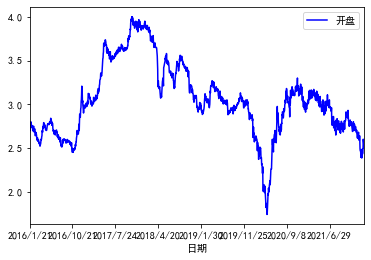

In [3]:
def draw_ts(timeSeries):
    f = plt.figure(facecolor='white')
    timeSeries.plot(color='blue')
    plt.show()
    
draw_ts(pd.DataFrame(national_debt['开盘']))

数据预处理

In [4]:
# 前(1563-600=963)天的开盘价作为训练集,表格从0开始计数，,0:1 是提取[0:1)列，前闭后开
training_set = national_debt.iloc[0:1563 - 600,0:].values  

#中间300天的数据作为验证集
valid_set= national_debt.iloc[1563 - 600:1563 - 300, 0:].values  

# 后300天的开盘价作为测试集
test_set = national_debt.iloc[1563 - 300:1563, 0:].values  

# 归一化
sc = MinMaxScaler(feature_range=(0, 1))  # 定义归一化：归一化到(0，1)之间
training_set_scaled = sc.fit_transform(training_set)  # 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化
valid_set = sc.transform(valid_set)
test_set = sc.transform(test_set)  # 利用训练集的属性对测试集进行归一化

#对开盘价数据进行归一化，方便后续可视化展示
sc_for_visual = MinMaxScaler(feature_range=(0, 1))  
y_test_for_visual_scaled = sc_for_visual.fit_transform(national_debt.iloc[0:1563 - 600, 0:1].values ) 
y_test_for_visual = sc_for_visual.transform(national_debt.iloc[1563 - 300:1563, 0:1].values )

得到训练集和测试集的数据

In [5]:
x_train = []
y_train = []

x_valid = []
y_valid = []

x_test = []
y_test = []

# 利用for循环，遍历整个训练集，提取训练集中连续10天的开盘价作为输入特征x_train，第11天的数据作为标签
for i in range(5, len(training_set_scaled)):
    x_train.append(training_set_scaled[i - 5:i, 1:]) 
    y_train.append(training_set_scaled[i, 0])


# 将训练集由list格式变为array格式
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], 5,4))
print(x_train)

#验证集
for i in range(5, len(valid_set)):
    x_valid.append(valid_set[i - 5:i,1:])
    y_valid.append(valid_set[i, 0])
x_valid, y_valid = np.array(x_valid), np.array(y_valid)
x_valid = np.reshape(x_valid, (x_valid.shape[0], 5,4))


# 测试集：csv表格中后300天数据
# 利用for循环，遍历整个测试集，提取测试集中连续10天的开盘价作为输入特征x_train，
# 第11天的数据作为标签，for循环共构建300-10=290组数据。
for i in range(5, len(test_set)):
    x_test.append(test_set[i - 5:i,1:])
    y_test.append(test_set[i, 0])
# 测试集变array并reshape为符合CNN和RNN输入要求：
#RNN: [送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0],5,4))

[[[0.18613607 0.16322581 0.18825782 0.49134615]
  [0.17907574 0.16451613 0.18953414 0.37692308]
  [0.18228498 0.19354839 0.18825782 0.43461538]
  [0.21052632 0.18709677 0.19463944 0.57307692]
  [0.23363286 0.21483871 0.24122527 0.54230769]]

 [[0.17907574 0.16451613 0.18953414 0.37692308]
  [0.18228498 0.19354839 0.18825782 0.43461538]
  [0.21052632 0.18709677 0.19463944 0.57307692]
  [0.23363286 0.21483871 0.24122527 0.54230769]
  [0.24775353 0.22322581 0.24569241 0.49230769]]

 [[0.18228498 0.19354839 0.18825782 0.43461538]
  [0.21052632 0.18709677 0.19463944 0.57307692]
  [0.23363286 0.21483871 0.24122527 0.54230769]
  [0.24775353 0.22322581 0.24569241 0.49230769]
  [0.24326059 0.22580645 0.25654116 0.39230769]]

 ...

 [[0.3491656  0.3316129  0.35992342 0.41634615]
  [0.35301669 0.32903226 0.35609445 0.43557692]
  [0.35686778 0.33612903 0.35928526 0.43557692]
  [0.35879332 0.33935484 0.37141034 0.42596154]
  [0.34531451 0.32258065 0.34779834 0.34807692]]

 [[0.35301669 0.32903226 0

训练模型

In [6]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [7]:
import os
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,BatchNormalization
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D,Flatten,AveragePooling1D
from tensorflow.keras import Model
from tensorflow import keras
from tensorflow.keras import layers


inputs = keras.Input(shape=(5, 4), name="input")
inputs_conv = layers.Conv1D(filters=64, kernel_size=1,activation='relu', strides=1)(inputs)

c1 = layers.Conv1D(filters=64, kernel_size=1,activation='relu', strides=1)(inputs_conv)
BatchNormalization()
Activation('relu')  
c2 = layers.Conv1D(filters=64, kernel_size=3,activation='relu', strides=1)(inputs_conv)
BatchNormalization() 
Activation('relu') 
c3 = layers.Conv1D(filters=64, kernel_size=5,activation='relu', strides=1)(inputs_conv)
BatchNormalization() 
Activation('relu') 


cnn_output = tf.concat([inputs_conv,c1,c2,c3], 1)

x = layers.LSTM(50,return_sequences=True)(cnn_output)
x = layers.Dropout(0.2)(x)
x = layers.LSTM(60)(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(20)(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs, name="outputs")
model.summary()

Model: "outputs"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 5, 4)]       0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 5, 64)        320         input[0][0]                      
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 5, 64)        4160        conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 3, 64)        12352       conv1d[0][0]                     
____________________________________________________________________________________________

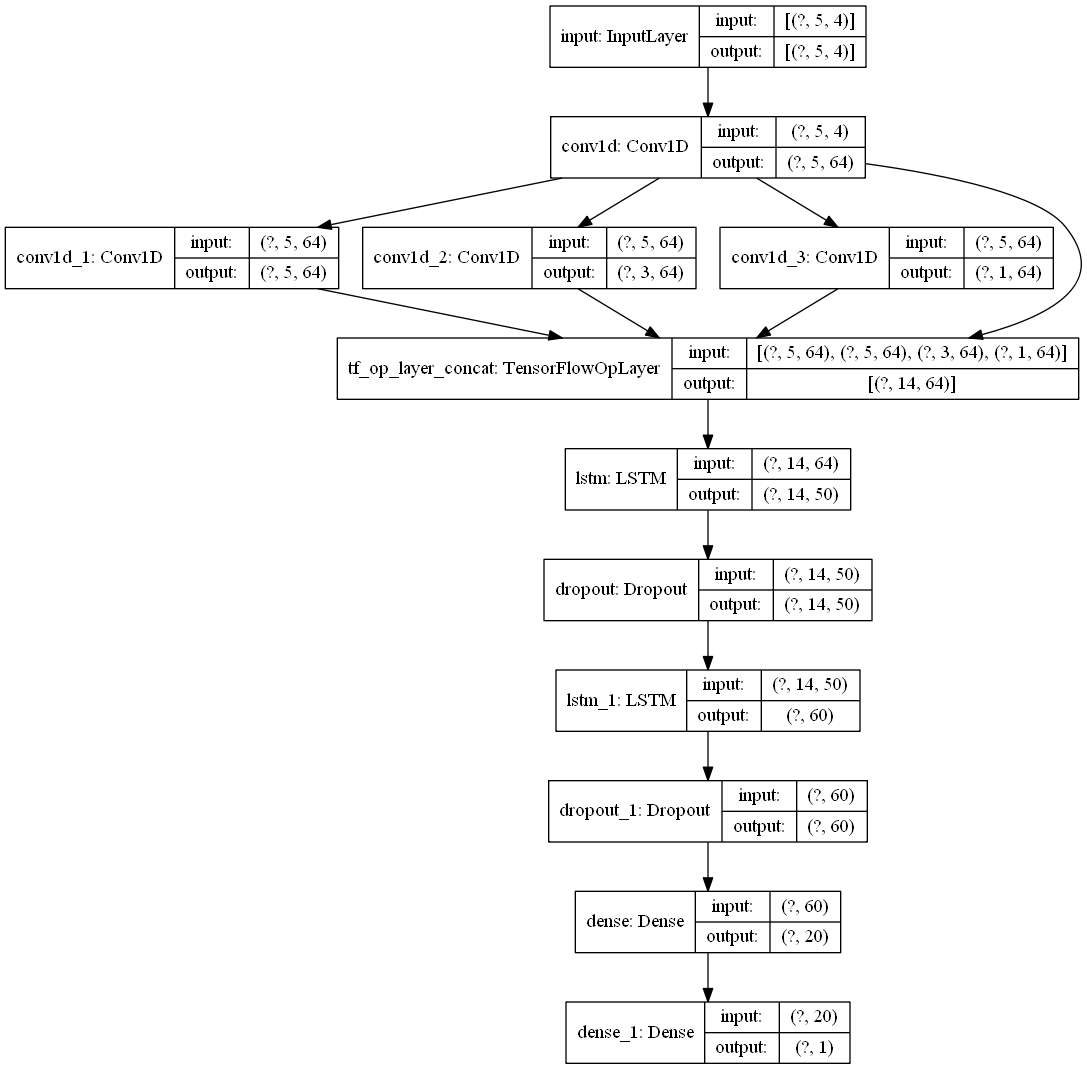

In [8]:
keras.utils.plot_model(model, "data/shape_info_by_cnn-lstm.png", show_shapes=True)

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-3),
              loss='mean_squared_error')  # 损失函数用均方误差

#该应用只观测loss数值，不观测准确率，所以删去metrics选项，一会在每个epoch迭代显示时只显示loss值
checkpoint_save_path = "./checkpoint/CMM-LSTM/CNN-LSTM_nation_debt.ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)

    
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='val_loss')

print('Train...')

history = model.fit(x_train, y_train,batch_size=64,epochs=80,
                    validation_data=(x_valid, y_valid),validation_freq=1,callbacks=[cp_callback,tensorboard_callback])

model.summary()

file = open('./data/weights_of_nation_debt_by_cnn-lstm.txt', 'w')  # 参数提取
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

Train...
Epoch 1/80
 1/15 [=>............................] - ETA: 0s - loss: 0.3040WARNING:tensorflow:From D:\Anaconda3\Anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
15/15 [==============================] - 2s 127ms/step - loss: 0.0664 - val_loss: 0.0371
Epoch 2/80
15/15 [==============================] - 1s 39ms/step - loss: 0.0136 - val_loss: 0.0270
Epoch 3/80
15/15 [==============================] - 1s 34ms/step - loss: 0.0058 - val_loss: 0.0199
Epoch 4/80
15/15 [==============================] - 1s 35ms/step - loss: 0.0038 - val_loss: 0.0193
Epoch 5/80
15/15 [==============================] - 1s 36ms/step - loss: 0.0034 - val_loss: 0.0187
Epoch 6/80
15/15 [==============================] - 0s 32ms/step - loss: 0.0033 - val_loss: 0.0173
Epoch 7/80
15/15 [==============================] - 1

16

11

4294

14

6

755

18

12

504

16

6

753

18

12

1516

16

6

771

18

12

2527

16

6

770

24

10

492

34

10

491

22

7

3251

28

10

491

38

10

492

26

7

3901

15

9

600

13

6

245

17

8

301

15

5

13

In [10]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 27920), started 1:29:15 ago. (Use '!kill 27920' to kill it.)

Text(0.5, 1.0, 'Training and Validation Loss')

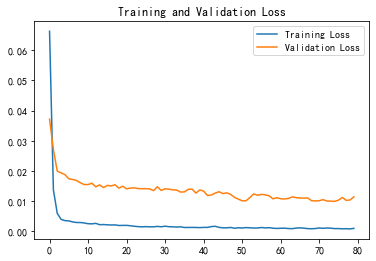

In [11]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss') #验证集用来选则最佳的超参数的值
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'national debt Price Prediction')

Text(0.5, 0, 'Time')

Text(0, 0.5, 'national debt Price')

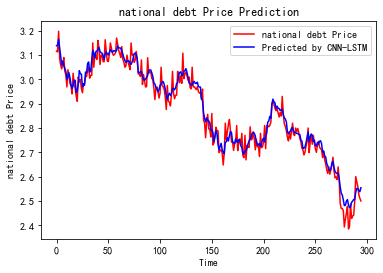

均方误差: 0.001092
均方根误差: 0.033041
平均绝对误差: 0.026521
10/10 - 0s - loss: 4.5439e-04
Test loss: 0.00045439499081112444


In [12]:
# 测试集输入模型进行预测
predicted_stock_price = model.predict(x_test)
# 对预测数据还原---从（0，1）反归一化到原始范围
predicted_stock_price = sc_for_visual.inverse_transform(predicted_stock_price)
# 对真实数据还原---从（0，1）反归一化到原始范围
real_stock_price = sc_for_visual.inverse_transform(y_test_for_visual[5:])
# 画出真实数据和预测数据的对比曲线
# 画出真实数据和预测数据的对比曲线
plt.figure(facecolor='white')
plt.plot(real_stock_price, color='red', label='national debt Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted by CNN-LSTM')
plt.title('national debt Price Prediction')
plt.xlabel('Time')
plt.ylabel('national debt Price')
plt.legend()
plt.show()

##########evaluate##############
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
mse = mean_squared_error(predicted_stock_price, real_stock_price)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt(mean_squared_error(predicted_stock_price, real_stock_price))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(predicted_stock_price, real_stock_price)
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)

loss = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", loss)


In [13]:
from sklearn.metrics import explained_variance_score
import seaborn as sns

cm = explained_variance_score(real_stock_price, predicted_stock_price)

print(cm )

0.97063476081063


可以用class的方式来实现，只是这种方式不利于可视化

Epoch 1/80
15/15 [==============================] - 2s 131ms/step - loss: 0.0573 - val_loss: 0.0490
Epoch 2/80
15/15 [==============================] - 0s 23ms/step - loss: 0.0170 - val_loss: 0.0510
Epoch 3/80
15/15 [==============================] - 0s 20ms/step - loss: 0.0129 - val_loss: 0.0509
Epoch 4/80
15/15 [==============================] - 0s 20ms/step - loss: 0.0106 - val_loss: 0.0541
Epoch 5/80
15/15 [==============================] - 0s 22ms/step - loss: 0.0112 - val_loss: 0.0533
Epoch 6/80
15/15 [==============================] - 0s 21ms/step - loss: 0.0106 - val_loss: 0.0545
Epoch 7/80
15/15 [==============================] - 0s 24ms/step - loss: 0.0110 - val_loss: 0.0585
Epoch 8/80
15/15 [==============================] - 0s 24ms/step - loss: 0.0104 - val_loss: 0.0576
Epoch 9/80
15/15 [==============================] - 0s 24ms/step - loss: 0.0087 - val_loss: 0.0559
Epoch 10/80
15/15 [==============================] - 0s 22ms/step - loss: 0.0100 - val_loss: 0.0575
Epoch 11

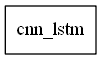

Model: "cnn_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            multiple                  320       
_________________________________________________________________
conv1d_5 (Conv1D)            multiple                  4160      
_________________________________________________________________
batch_normalization_3 (Batch multiple                  256       
_________________________________________________________________
activation_3 (Activation)    multiple                  0         
_________________________________________________________________
conv1d_6 (Conv1D)            multiple                  12352     
_________________________________________________________________
batch_normalization_4 (Batch multiple                  256       
_________________________________________________________________
activation_4 (Activation)    multiple                  0  

In [21]:
import os
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,BatchNormalization
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D,Flatten,AveragePooling1D
from tensorflow.keras import Model
from tensorflow import keras
from tensorflow.keras import layers

class CNN_LSTM(Model):
    def __init__(self):
        super(CNN_LSTM, self).__init__()
        self.conv1 = Conv1D(filters=64, kernel_size=1,activation='relu', strides=1)
        self.c1 = Conv1D(filters=64, kernel_size=1,activation='relu', strides=1)
        self.b1 = BatchNormalization() # BN层
        self.a1 = Activation('relu')    # 激活层  
        self.c2 = Conv1D(filters=64, kernel_size=3,activation='relu', strides=1)
        
        self.b2 = BatchNormalization() # BN层
        self.a2 = Activation('relu')    # 激活层  
        
        self.c3 = Conv1D(filters=64, kernel_size=5,activation='relu', strides=1)        
        self.b3 = BatchNormalization() # BN层
        self.a3 = Activation('relu')    # 激活层  
      
        self.f1 = LSTM(50,return_sequences=True)
        self.d2 = Dropout(0.2)
        self.f2 = LSTM(60)
        self.d3 = Dropout(0.2)
        self.f3 = Dense(20)
        self.d4 = Dropout(0.2)
        self.f4 = Dense(1, activation='linear')

    def call(self, x):
        x = self.conv1(x)
        c1 = self.c1(x)
        b1 = self.b1(c1)
        a1 = self.a1(b1)
        
        c2 = self.c2(x)
        b2 = self.b2(c2)
        a2 = self.a2(b2)
        
        c3 = self.c3(x)
        b3 = self.b3(c3)
        a3 = self.a3(b3)

        x = tf.concat([x,a1,a2,a3], 1)
        
        
        x = self.f1(x)
        x = self.d2(x)
        x = self.f2(x)
        x = self.d3(x)
        x = self.f3(x)
        x = self.d4(x)
        y = self.f4(x)
        return y


model = CNN_LSTM()

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-3),
              loss='mean_squared_error')  # 损失函数用均方误差

# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit(x_train, y_train,batch_size=64,epochs=80,
                    validation_data=(x_valid, y_valid),validation_freq=1,callbacks=[tensorboard_callback])

keras.utils.plot_model(model, "data/shape_info_by_cnn-lstm.png", show_shapes=True)

model.summary()

In [15]:
%tensorboard --logdir logs

#http://localhost:6006，可以看到网页版的界面

Reusing TensorBoard on port 6006 (pid 27920), started 1:59:27 ago. (Use '!kill 27920' to kill it.)